In [1]:
# Se importan las librerías necesarias 

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import cv2
import os
from skimage.io import imread
import skimage.filters as filters
import os
from os import listdir
import plantcv as pcv

# Función  para gráficar una imagen 
def plot(imagen,color='black',title=None,cmapa='gray',pic = False,subplot  = (1,1,1),vmin = 0, vmax = 255):
    if pic == True:
        plt.figure(figsize=(15,8))
    plt.subplot(subplot[0],subplot[1],subplot[2])
    plt.axis('off')
    plt.imshow(imagen,cmap = cmapa,vmin = vmin, vmax = vmax)
    plt.title(title,color = color)
# Función para cargar una imagen en escala de grises
def load_gray_image(image_path):
    
    coloured_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(coloured_image, cv2.COLOR_BGR2GRAY)
    return gray_image

# Función para crear histogramas
def plot_img_hist (image,title,subrows,subcols,num,size1,size2):
    fig = plt.figure(figsize=(size1,size2))
    plt.subplot(subrows,subcols,num)
    plt.imshow(image,cmap='gray');plt.title(title)
    color = ('r','g','b')
    plt.subplot(subrows,subcols,num+1)
    plt.title(" Histograma " + title)

    if len(image.shape) > 2 :            
        for i,col in enumerate(color):
            histr = cv2.calcHist([image],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
    else:
        hist,bins = np.histogram(image.ravel(),256,[0,256])
        plt.plot(hist, color='gray' )
        plt.xlim([0,256])

# Función para binarizar una imagen
def threshold(img,tipo,t):
    _ , image = cv2.threshold(img,t,255,tipo)
    lista = {0:'THRESH_BINARY',
             1:'THRESH_BINARY_INV',
             2:'THRESH_TRUNC',
             3:'THRESH_TOZERO',
             4:'THRESH_TOZERO_INV',
             8:'THRESH_OTSU',
             16:'THRESH_TRIANGLE',
             7:'THRESH_MASK'    }
    plot(image, pic = True,subplot = (1,2,2),title = 'Imagen binarizada con tipo de umbralización {}.'.format(lista[tipo]))
    plot(img,subplot = (1,2,1), title= f'Imagen filtrada')
    return _

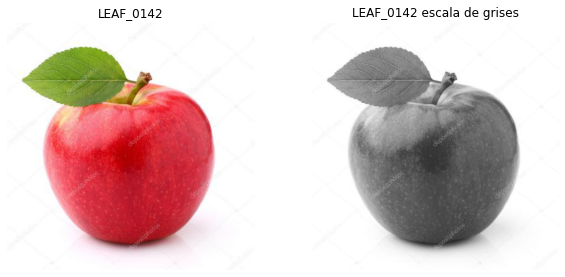

In [2]:
## Comprobamos las funciones de importacion y gráficar
imagen = '0142'
carpeta = 'DataSet'
img_test = cv2.cvtColor(cv2.imread(f'{carpeta}/train/LEAF_{imagen}.jpg'), cv2.COLOR_BGR2RGB)
img_gray = load_gray_image(f'{carpeta}/train/LEAF_{imagen}.jpg')
plt.figure(figsize=(10,10))
plot(img_test,subplot=(2,2,1) ,title=f'LEAF_{imagen}')
plot(img_gray,subplot=(2,2,2) ,title=f'LEAF_{imagen} escala de grises')

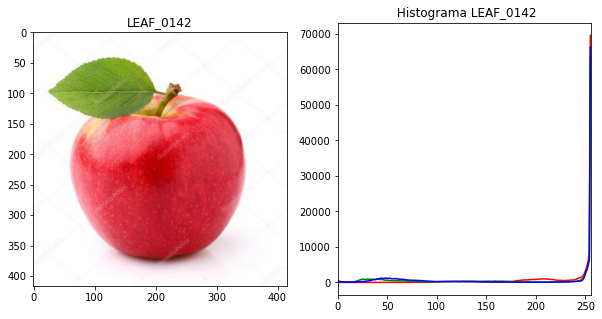

In [3]:
## Gráficamos los histogramas de color para una imagen de prueba
plot_img_hist(img_test,f'LEAF_{imagen}',1,2,1,10,5)

In [70]:
# En el segundo argumento de la función, el número indica el canal
hist_r = cv2.calcHist([img_test],[2],None,[256],[0,256])
dato = 0
count = 0
posicion = 0
for i in hist_r[0:230]:
    if i > dato:
        dato = i
        posicion = count
    i += 1
    count += 1
print(posicion, dato[0])

48 1228.0


In [65]:
median_value = np.percentile(hist_r[0:229], 75) 
print(median_value)

297.0


In [66]:
dato = 0
count = 0
posicion = 0
for i in hist_r[0:230]:
    if i == median_value:
        dato = i
        posicion = count
    i += 1
    count += 1
print(posicion, dato[0])

120 298.0
